## Original Resampling function
def Resampling(image, newsize, roisize, meta=image ,origin = None, is_label = False):
    #isize = image.GetSize()
    ivs = image.GetSpacing()
    
    if image.GetNumberOfComponentsPerPixel() == 1:
        minmax = sitk.MinimumMaximumImageFilter()
        minmax.Execute(image)
        minval = minmax.GetMinimum()
    else:
        minval = None
    
    osize = (newsize, newsize )
    

    
    ovs = [ vs * s / os for vs, s, os in zip(ivs, roisize, osize) ]
    

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(osize)
    if origin is not None:
        resampler.SetOutputOrigin(origin)
    else:
        resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputSpacing(ovs)
    if minval is not None:
        resampler.SetDefaultPixelValue(minval)
    if is_label:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)

    resampled = resampler.Execute(image)

    return resampled

## Classify data

In [2]:
import numpy as np
import random

In [3]:
small_mix = "000,004,006,009,010,011,014,015,016,018,021,022,026,029,033,034,036,039,040,041,046,051,052,054,057,059,061,062,065,066,071,075,076,082,083,085,086,087,095,096,097,098,100,104,105,108,111,113,115,116,117,118,119,122,123,126,128,131,132,136,138,140,142,144,147,148,150,151,153,154,156,157,158,159,160,163,166,167,168,169,171,174,175,176,177,198,201,203,204,207,208"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,109,139,149,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,042,056,070,079,088,114,135"
small_black = "001,002,003,007,013,017,019,027,031,032,035,038,043,044,045,048,050,053,064,068,072,077,080,089,090,091,094,099,101,103,106,110,121,124,127,129,130,133,146,162,164,170,173,185,187,196"

hard_mix = "020,023,049,063,081,120,156,191,209"

In [4]:
random.shuffle(smallMix)
random.shuffle(bigMix)
random.shuffle(bigBlack)
random.shuffle(smallBlack)
random.shuffle(hardMix)

NameError: name 'smallMix' is not defined

In [ ]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,049,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,156,191,209,057,098,150,057,098,150"
mix_with_black = "015,026,058,060,069,074,082,084,093,102,112,119,124,125,134,137,141,145,152,155,156,161,178,182,183,190,195,200"
special = "165,194,206,041,205,184,005,015,154,037,021,188,193,143,208,180,046"

In [ ]:
a = len(true_small_mix.split(","))
b = len(small_white.split(","))
c = len(big_mix.split(","))
d = len(big_black.split(","))
e = len(small_black.split(","))
f = len(hard_mix.split(","))
g = len(mix_with_black.split(","))
h = len(special.split(","))
print(b)
print(a+b+c+d+e+f+g+h)

In [ ]:
a = true_small_mix.split(",")
b = small_white.split(",")
c = big_mix.split(",")
d = big_black.split(",")
e = small_black.split(",")
f = hard_mix.split(",")
g = mix_with_black.split(",")
h = special.split(",")

print(sorted(a+b+c+d+e+f+g+h))
print(len(sorted(a+b+c+d+e+f+g+h)))
ss = sorted(a+b+c+d+e+f+g+h)

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

#['015', '041', '049', '082', '102', '124', '156', '178']
loss = []
count = []
overlap = []
ignorePatient = ["005","151","165","194"]
for x in range(210):
    ss.count(str(x).zfill(3))
for x in range(210):
#     if str(x).zfill(3) in ignorePatient:
#         continue
        
    cnt = 0
    cnt += a.count(str(x).zfill(3))
    cnt += b.count(str(x).zfill(3))
    cnt += c.count(str(x).zfill(3))
    cnt += d.count(str(x).zfill(3))
    cnt += e.count(str(x).zfill(3))
    cnt += f.count(str(x).zfill(3))
    cnt += g.count(str(x).zfill(3))
    cnt += h.count(str(x).zfill(3))
    
    if cnt == 0:
        loss.append(str(x).zfill(3))
    
    if cnt>1:
        overlap.append(str(x).zfill(3))
        
    count.append(cnt)
print(overlap)
print(loss)
print(np.where(np.array(count)>0, True, False).sum())
print(count)

In [2]:
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [3]:
ignorePatient = [5,151,165,194]

In [115]:
#df = pd.DataFrame(columns = ["id", "slice number", "tag", "mean", "std", "var", "max", "min"])
df = pd.DataFrame(columns = ["id", "slice number", "tag"])
df.set_index(["id", "slice number", "tag"], inplace=True)
# df.loc[(0,0,"s"), "a"] = 100
# df.loc[(0,1,"a"), "a"] = 200
# df.loc[(0,1,"s"), "a"] = 300
# df.loc[(0,2,"s"), "a"] = 400
# df.loc[(0,2,"a"), "a"] = 500
print(df)

Empty DataFrame
Columns: [id, slice number, tag]
Index: []


In [166]:
sliceNumbers = 0
for x in range(210):
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumbers += len(labelArray[:,0,0])
    
    
df = pd.DataFrame(index=range(sliceNumbers*2))
print(df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[214668 rows x 0 columns]


In [169]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

         id  slice number     tag  Mean  Std  Var  Max  Min
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN
...     ...           ...     ...   ...  ...  ...  ...  ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN

[214668 rows x 8 columns]
                         Mean  Std  Var  Max  Min
id  slice number tag                             
0   0            kidney   NaN  NaN  NaN  NaN  NaN
    1            kidney   NaN  NaN  NaN  NaN  NaN
    2            kidney   NaN  NaN  NaN  NaN  NaN
   

         id  slice number     tag  Mean  Std  Var  Max  Min  Size
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN     0
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN     0
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN     0
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN     0
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN     0
...     ...           ...     ...   ...  ...  ...  ...  ...   ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN     0
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN     0
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN     0
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN     0
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN     0

[214668 rows x 9 columns]
         id  slice number     tag        Mean        Std          Var  \
162       0           162  kidney  -37.253151   9.672718    93.561468   
163       0           163  kidney  

In [185]:
df = pd.read_csv("sagital.csv")
kidSize = []
canSize = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kSize = np.where(labArray==1, True, False).sum()
        cSize = np.where(labArray==2, True, False).sum()
        
        kidSize.append(kSize)
        canSize.append(cSize)
        

df["Size"] = kidSize + canSize


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital2.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [102]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [103]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,191,209,057,098,150"
mix_with_black = "015,026,058,060,069,074,084,093,112,119,125,134,137,141,145,152,155,156,161,182,183,190,195,200"
special = "165,194,206,205,184,005,154,037,021,188,193,143,208,180,046"

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

In [104]:
df = pd.read_csv("dfAboutKidneyAndCancer.csv")
print(df)

       Unnamed: 0   id  slice number     tag        Mean        Std  \
0             162    0           162  kidney  -37.253151   9.672718   
1             163    0           163  kidney   37.572537  49.860718   
2             164    0           164  kidney   85.865282  86.790756   
3             165    0           165  kidney   99.003225  94.184951   
4             166    0           166  kidney  129.435100  84.773216   
...           ...  ...           ...     ...         ...        ...   
52505      214501  209           344  cancer   62.450544  56.845241   
52506      214502  209           345  cancer   75.063078  58.664732   
52507      214503  209           346  cancer   89.271236  35.083031   
52508      214504  209           347  cancer   77.540750  10.665388   
52509      214505  209           348  cancer   73.605345   9.064534   

               Var         Max         Min  Size  
0        93.561468  -11.861316  -11.861316    22  
1      2486.091249  127.743541  127.743541   

In [105]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
c = []
for x in range(210):
    sx = str(x).zfill(3)
    if sx in ignorePatient:
        continue
    if sx in trueSmallMix:#red
        c.append(0)
    if sx in smallWhite:#blue
        c.append(1)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(3)
    if sx in smallBlack:#black
        c.append(4)
    if sx in hardMix:#"gray"
        c.append(5)
    if sx in mixWithBlack:#"pink"
        c.append(6)
    if sx in specialOne:#"skyblue"
        c.append(7)

In [6]:
cmap = ListedColormap(colors)

In [160]:
df_q = df.query("tag=='cancer'")
canGroup = df_q.groupby("id")

#canGroup = df.groupby("id").apply("tag=='cancer'")
dff = canGroup[("id","Mean")].mean()
s = canGroup["Size"].mean().sort_values()
print(dff.info())
dff = pd.concat([dff, s], axis=1)
dff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 0 to 209
Data columns (total 2 columns):
id      206 non-null int64
Mean    206 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB
None


,id,Mean,Size
id,,,
0,0,115.864027,138.666667
1,1,61.593494,82.916667
2,2,44.756910,326.844828
3,3,73.913018,150.324324
4,4,66.122565,245.261905


In [161]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
colors = ["red", "blue", "yellow"]
c = []
for x, ss in enumerate(dff["Size"]):
    sx = str(x).zfill(3)
#     if sx in ignorePatient:
#         continue
    if sx in trueSmallMix:#red
        c.append(2)
    if sx in smallWhite:#blue
        c.append(0)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(1)
    if sx in smallBlack:#black
        c.append(1)
    if sx in hardMix:#"gray"
        c.append(2)
    if sx in mixWithBlack:#"pink"
        c.append(1)
    if sx in specialOne:#"skyblue"
        c.append(2)
cmap = ListedColormap(colors)
print(c)

[2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2]


In [162]:
colors = ["red", "pink", "blue", "skyblue", "darkgreen"]
c = []
sw = []
bw = []
sm = []
bm = []
sb = []
bb = []
for i, mm, (x, ss) in zip(dff["id"],dff["Mean"], enumerate(dff["Size"])):
    sx = str(int(i)).zfill(3)
#     if sx in ignorePatient:
#         continue
    
    if mm<50:
        if ss<300:
            c.append(0)
            sw.append(sx)
        else:
            c.append(1)
            bw.append(sx)
    
    elif mm<100:
        if ss<300:
            c.append(2)
            sm.append(sx)
        else:
            c.append(3)
            bm.append(sx)
    else:
        if ss<300:
            c.append(4)
            sb.append(sx)
        else:
            c.append(5)
            bb.append(sx)

cmap = ListedColormap(colors)
print(c)
print("sw = ", sw)
print("bw = ", bw)
print("sm = ", sm)
print("bm = ", bm)
print("sb = ", sb)
print("bb = ", bb)
print(len(sw)+len(bw)+len(bm)+len(sm)+len(sb)+len(bb))

[4, 2, 1, 2, 2, 2, 0, 3, 4, 4, 3, 3, 3, 4, 4, 5, 4, 4, 0, 4, 0, 4, 4, 3, 3, 3, 2, 1, 3, 3, 2, 2, 4, 5, 0, 5, 0, 1, 2, 2, 4, 1, 4, 1, 3, 1, 3, 3, 2, 2, 3, 2, 1, 2, 3, 1, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 1, 0, 5, 1, 4, 2, 3, 2, 2, 2, 4, 3, 3, 1, 2, 4, 0, 3, 2, 2, 3, 3, 3, 3, 2, 3, 0, 0, 1, 4, 4, 4, 1, 4, 2, 1, 0, 2, 3, 0, 3, 3, 5, 3, 5, 3, 1, 1, 4, 5, 2, 3, 3, 4, 2, 3, 4, 2, 2, 3, 0, 4, 2, 3, 5, 2, 1, 1, 3, 2, 0, 2, 1, 4, 2, 5, 3, 3, 1, 0, 2, 2, 3, 2, 2, 2, 2, 0, 2, 3, 4, 3, 3, 5, 3, 3, 2, 3, 4, 5, 3, 2, 3, 3, 0, 2, 2, 1, 5, 3, 3, 3, 3, 4, 2, 3, 1, 3, 3, 2, 3, 2, 2, 3, 0, 3, 1, 1, 4, 3, 3, 4, 5, 2, 3, 2, 3, 0, 2, 2]
sw =  ['007', '019', '021', '035', '037', '068', '083', '093', '094', '103', '106', '127', '137', '146', '155', '173', '193', '207']
bw =  ['002', '028', '038', '042', '044', '046', '053', '056', '067', '070', '080', '095', '099', '102', '113', '114', '133', '134', '139', '145', '176', '185', '196', '197']
sm =  ['001', '003', '004', '006', '027', '031', '032', '039', '040', '04

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24461700f0>,
      dtype=object)

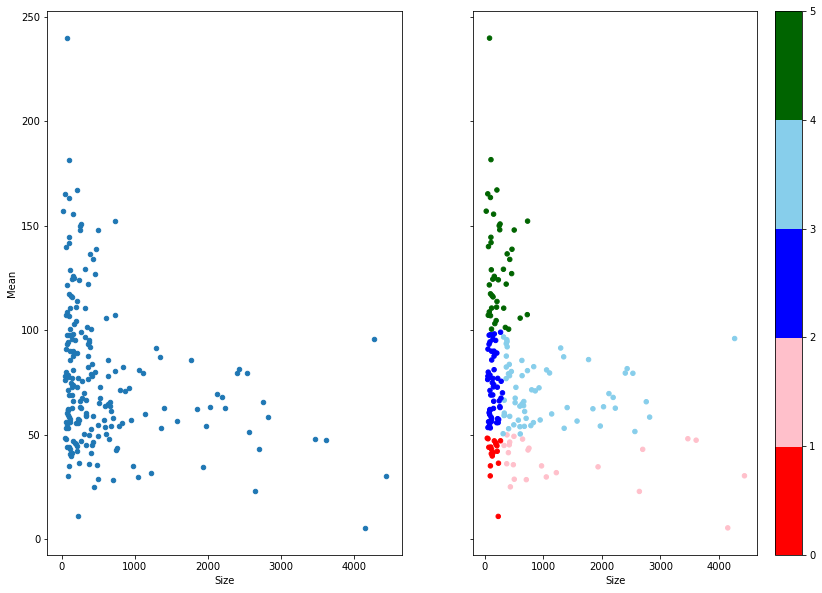

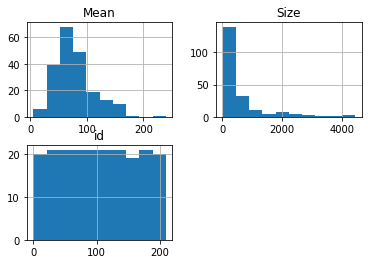

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# 1.普通のプロット

dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[0])
dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[1], c=c, cmap=cmap)
dff.hist()
# for x, y in dff.iterrows():
#     axes[1].annotate(int(y[0]), xy=(y[1],y[0]), size=2)
# # 2.離散値を色で表す
# df[0:150].plot(x='ad', y='ba', kind='scatter', c='ef', cmap='Blues', ax=axes.flatten()[1])
# # 3.離散値をバブルサイズで表す（ちょっと数は減らしてる）
# df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, ax=axes.flatten()[2])
# # 4.両方同時に使う
#df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, c='ef', ax=axes.flatten()[3])

## Make random dataset

In [3]:
import numpy as np
import random

In [7]:
sw =  ['002', '007', '019', '021', '028', '035', '037', '038', '044', '046', '053', '068', '080', '083', '093', '094', '095', '099', '103', '106', '113', '127', '133', '134', '137', '145', '146', '155', '173', '176', '185', '193', '196', '197', '207']
bw =  ['042', '056', '067', '070', '102', '114', '139']
sm =  ['001', '003', '004', '006', '011', '012', '013', '024', '026', '027', '029', '031', '032', '039', '040', '045', '047', '048', '049', '050', '051', '052', '054', '057', '058', '060', '061', '062', '063', '064', '065', '066', '072', '074', '075', '076', '081', '084', '085', '086', '087', '089', '090', '091', '101', '104', '105', '108', '110', '112', '117', '118', '119', '121', '122', '124', '125', '126', '129', '130', '132', '136', '138', '141', '143', '144', '147', '148', '149', '150', '152', '153', '154', '156', '157', '159', '160', '162', '163', '164', '166', '169', '170', '171', '174', '175', '178', '179', '180', '183', '184', '187', '188', '190', '191', '195', '199', '200', '203', '204', '205', '206', '208', '209']
bm =  ['008', '025', '030', '055', '073', '078', '079', '088', '092', '107', '135', '172', '181', '186', '189', '192']
sb =  ['000', '009', '010', '014', '015', '016', '017', '018', '020', '022', '023', '033', '034', '036', '041', '043', '059', '069', '071', '077', '082', '096', '097', '098', '100', '109', '111', '115', '116', '120', '123', '128', '131', '140', '142', '158', '161', '167', '168', '177', '182', '198', '201', '202']
bb =  []
ignorePatient = ["005","151","165","194"]

In [8]:
random.shuffle(sw)
random.shuffle(bw)
random.shuffle(sm)
random.shuffle(bm)
random.shuffle(sb)
random.shuffle(bb)

In [12]:
a = len(sw)
b = len(bw)
c = len(sm)
d = len(bm)
e = len(sb)
f = len(bb)

        
validation = sw[:int(a/7)] + bw[:int(b/7)] + sm[:int(c/7)] \
              + bm[:int(d/7)] + sb[:int(e/7)] + bb[:int(f/7)] \

testing = sw[int(a/7):int(a/7)*2] + bw[int(b/7):int(b/7)*2] + sm[int(c/7):int(c/7)*2] \
              + bm[int(d/7):int(d/7)*2] + sb[int(e/7):int(e/7)*2] + bb[int(f/7):int(f/7)*2] \

training = sw[int(a/7)*2:] + bw[int(b/7)*2:] + sm[int(c/7)*2:] \
              + bm[int(d/7)*2:] + sb[int(e/7)*2:] + bb[int(f/7)*2:] \
              

    
print(len(validation))
print(len(testing))
print(len(training))
# testing.append("151")
# training.remove("151")
# x = random.randint(0,len(testing))
# training.append(testing[x])
# testing.remove(testing[x])
    
cnt = 0
ccc = validation+testing+training
while len(training)!=150:
    x = random.randint(0,len(training))
    testing.append(training[x])
    training.remove(training[x])
    x = random.randint(0,len(training))
    validation.append(training[x])
    training.remove(training[x])
    
print(len(validation))
print(len(testing))
print(len(training))

print("validation = ",validation)
print("training = ", training)
print("testing = ", testing)
for x in validation:
    if x in ignorePatient:
        print(x)

28
28
150
28
28
150
validation =  ['007', '145', '173', '021', '019', '067', '141', '045', '074', '199', '130', '184', '087', '117', '148', '170', '063', '091', '163', '188', '008', '079', '116', '016', '123', '096', '111', '015']
training =  ['068', '099', '037', '046', '196', '038', '080', '103', '113', '207', '094', '134', '095', '146', '137', '106', '185', '127', '028', '155', '093', '002', '053', '193', '133', '114', '056', '070', '139', '042', '195', '105', '011', '032', '112', '054', '051', '206', '187', '147', '191', '132', '064', '065', '006', '174', '204', '031', '159', '101', '118', '124', '152', '166', '072', '150', '160', '026', '164', '190', '138', '179', '039', '149', '049', '178', '040', '081', '085', '121', '157', '075', '062', '108', '029', '013', '090', '104', '060', '205', '203', '143', '183', '066', '169', '156', '027', '058', '154', '052', '180', '209', '048', '001', '153', '200', '110', '050', '122', '089', '084', '012', '144', '086', '024', '061', '135', '181', 

In [10]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import glob
import os

In [27]:
training = ['207', '080', '095', '099', '007', '028', '053', '137', '176', '106', '083', '127', '094', '103', '193', '019', '197', '037', '196', '035', '113', '146', '185', '093', '145', '102', '056', '042', '139', '067', '180', '061', '026', '174', '153', '001', '064', '075', '091', '129', '147', '058', '178', '085', '086', '203', '003', '138', '144', '051', '122', '024', '076', '205', '121', '063', '108', '027', '188', '184', '004', '160', '119', '164', '045', '130', '072', '049', '166', '154', '209', '143', '013', '163', '074', '081', '048', '052', '126', '087', '149', '117', '136', '012', '206', '040', '191', '054', '124', '066', '195', '187', '132', '057', '150', '060', '089', '104', '170', '159', '171', '169', '039', '125', '199', '011', '008', '073', '055', '107', '079', '092', '192', '030', '186', '181', '088', '172', '034', '018', '120', '082', '177', '014', '158', '109', '100', '131', '033', '010', '140', '069', '022', '123', '071', '023', '098', '116', '128', '043', '059', '161', '115', '097', '167', '017', '015', '201', '096', '202']
ignorePatient = ["005","151","165","194"]

In [51]:
data10 = {"mean" : [], "var" : []}
for x in training:
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image1_*.mha"))
    
    
    mean = [0,0]
    var = [0,0]
    check = True
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
        
        if check:
            check = False
            img0Arrays = img0Array
            img1Arrays = img1Array
        
        else:
            img0Arrays = np.dstack([img0Arrays, img0Array])
            img1Arrays = np.dstack([img1Arrays, img1Array])
        
    data10["mean"].append([img0Arrays.mean(), img1Arrays.mean()])
    data10["var"].append([img0Arrays.var(), img1Arrays.var()])

In [52]:
print(np.array(data25["mean"]).mean(), np.array(data25["var"]).mean())
print(np.array(data50["mean"]).mean(), np.array(data50["var"]).mean())
print(np.array(data75["mean"]).mean(), np.array(data75["var"]).mean())
print(np.array(data10["mean"]).mean(), np.array(data10["var"]).mean())

12.218994473904107 214879.4315322188<br>
12.570158569339881 117897.898996187<br>
12.920030214222686 50587.0624435342<br>
11.863239299971964 341530.5333371568<br>

In [53]:
import csv # csvモジュールをインポート

In [56]:
with open("data25.csv", "w") as f: # 文字コードをShift_JISに指定
    writer = csv.writer(f, lineterminator="\n") # writerオブジェクトの作成 改行記号で行を区切る
    writer.writerows(data25["mean"]) # cs

## Make dataframe about alpha=0.25, 0.50, 0.75 (It doesn't finished)

In [ ]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image1_*.mha"))
    
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
    
    ## Extracting data is finished

    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [2]:
import matplotlib.pyplot as plt

In [4]:
with open('/home/vmlab/Desktop/KIDNEY/text/result.txt') as f:
    file = f.readlines()

In [5]:
alpha = []
dice =[]
for x in file:
    xx = x.split()
    if xx[0][1].lower()=='l':
        alpha.append(1.0 - float(xx[1].replace('<br>', '')))
    elif xx[1][0].lower()=='c':
        dice.append(float(xx[2].replace('<br>', '')))
        
for x, y in zip(alpha, dice):
    print(x,y)

1.0 0.6168616106368008
0.95 0.6427303569773539
0.9 0.6331813067769961
0.85 0.6142015511082867
0.8 0.6127422154373728
0.75 0.6390143488447617
0.7 0.6144467124985238
0.6 0.6189194623422858
0.55 0.6227715693641677
0.5 0.6332673342763784
0.44999999999999996 0.6330643159830883
0.4 0.6154617736995323
0.35 0.6162038113721422
0.30000000000000004 0.6194164344665026
0.25 0.619761210861021
0.19999999999999996 0.6227163976428916
0.15000000000000002 0.615614442828826
0.09999999999999998 0.6066524546095309
0.050000000000000044 0.6128789202649746
0.0 0.6330005107201063


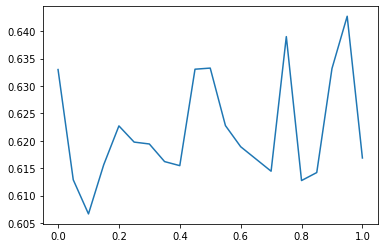

In [6]:
plt.plot(alpha, dice)

In [2]:
import SimpleITK as sitk
import numpy as np
import sys
import matplotlib.pyplot as plt

In [88]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/slice/original/image/case_00000/image0_13.mha')
imgArray = sitk.GetArrayFromImage(img)
print(imgArray.shape)
print(imgArray.max(), imgArray.min())

(256, 256)
770.6985426754006 -176.50363717769574


In [89]:
times = 10**3

In [90]:
print(imgArray[33][33])
print(imgArray.min(), imgArray.max())

imgArray = imgArray + 1024
imgArray = np.clip(imgArray, 0, 2048)
imgArray = imgArray * times

-103.72275289304488
-176.50363717769574 770.6985426754006


In [91]:
ctRange = 2048 * times + 1

In [93]:
hist,_ = np.histogram(imgArray, bins=ctRange, range=[0, ctRange ], density=True)

hist.max()

0.0077972412109375

In [ ]:
HIST = np.array([0.0] * ctRange)

for x in range(210):
    sx = str(x).zfill(3)
    if sx not in training:
        continue

    p = Path('/home/vmlab/Desktop/data/slice/hist_1.0/image/case_00' + sx)
    if not p.exists():
        print('File does not exist. ')
        sys.exit()
    for i in p.glob('image*'):
        img = sitk.ReadImage(str(i))
        imgArray = sitk.GetArrayFromImage(img)
        imgArray = imgArray + 1024
        imgArray = np.clip(imgArray, 0, 2048)
        hist, _ = np.histogram(imgArray.ravel(), ctRange, [0, ctRange], density=True)
        HIST += hist
    print('case_00' + sx + 'done. ')

HIST = HIST / HIST.sum()

In [15]:
import os

In [79]:
hists = np.load('/home/vmlab/Desktop/data/sumHistFloat.npy')
times = 10**3 #args
alpha = 1.0  #args

In [80]:
print('Loading npy file...')
npyFile = os.path.expanduser('/home/vmlab/Desktop/data/sumHistFloat.npy')
HIST = np.load(npyFile)
print('Loading it has done. ')
aHIST = HIST * alpha + (1 - alpha) / (2048 * times)

#Make CDF
cdf = aHIST.cumsum()
cdf_m = np.ma.masked_equal(cdf,0)
temp = (cdf_m - cdf_m.min())/(cdf_m.max()-cdf_m.min())
cdf_m = 2048 * times * temp
cdfI = np.ma.filled(cdf_m,0).astype('int')
cdfF = np.ma.filled(cdf_m,0).astype('float32')
print('Making CDF has done.' )
print(cdfI)
print(cdfF)

Loading npy file...
Loading it has done. 
Making CDF has done.
[      0       0       0 ... 2047928 2047928 2048000]
[0.0000000e+00 0.0000000e+00 2.3323635e-03 ... 2.0479285e+06 2.0479285e+06
 2.0480000e+06]


In [81]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/slice/original/image/case_00000/image0_13.mha')
imgArray = sitk.GetArrayFromImage(img)
imgArray = imgArray + 1024
imgArray = np.clip(imgArray, 0, 2048)
imgArray = imgArray * times

print(imgArray)
print()
imgArray = np.array(imgArray, dtype=np.int)
print('aa',imgArray)
print('bb',cdfI[imgArray])
print('cc',cdfF[imgArray])

imgArray = cdfF[imgArray] 
imgArray = imgArray / times - 1024

print('dd', imgArray)

i = sitk.ReadImage('/home/vmlab/Desktop/KIDNEY/test/image/case_00000/image0_13.mha')
ia = sitk.GetArrayFromImage(i)
print('ee',ia)

[[ 938983.93487945  942176.1513168   945368.36775415 ...  930011.43702338
   927301.56610797  847496.3628223 ]
 [ 930110.69712646  934261.25461847  938411.81211049 ...  937850.43450953
   935682.6958195   847496.3628223 ]
 [ 921237.45937347  926346.35792015  931455.25646683 ...  945689.43199568
   944063.82553104  847496.3628223 ]
 ...
 [1440411.97717126 1446222.70509205 1452033.43301283 ... 1067320.78257631
  1067395.41075891  847496.3628223 ]
 [1440411.97717126 1446222.70509205 1452033.43301283 ... 1067320.78257631
  1067395.41075891  847496.3628223 ]
 [ 847496.3628223   847496.3628223   847496.3628223  ...  847496.3628223
   847496.3628223   847496.3628223 ]]

aa [[ 938983  942176  945368 ...  930011  927301  847496]
 [ 930110  934261  938411 ...  937850  935682  847496]
 [ 921237  926346  931455 ...  945689  944063  847496]
 ...
 [1440411 1446222 1452033 ... 1067320 1067395  847496]
 [1440411 1446222 1452033 ... 1067320 1067395  847496]
 [ 847496  847496  847496 ...  847496  847496

In [15]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [16]:
alpha = ['0.0', '0.20', '0.40', '0.60', '0.80', '1.0']

for a in alpha:
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    iaa = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_float_' + a + '/image/case_00000/image0_13.mha')
    iaaa = sitk.GetArrayFromImage(iaa)
    print(ia[0, :5], iaaa[0, :5])

[-85 -81 -78 -76 -80] [-85.01703  -81.823975 -78.63202  -76.95599  -80.737976]
[-173 -161 -152 -147 -158] [-171.45227 -161.44293 -152.19415 -147.62878 -158.21442]
[-261 -240 -225 -217 -235] [-257.88898 -241.06323 -225.7575  -218.3028  -235.6922 ]
[-348 -319 -299 -287 -312] [-344.32727 -320.68494 -299.32214 -288.97803 -313.17126]
[-436 -398 -372 -357 -389] [-430.76703 -400.30798 -372.888   -359.65442 -390.6516 ]
[-524 -477 -446 -427 -466] [-517.2081  -479.93237 -446.4552  -430.33215 -468.1333 ]


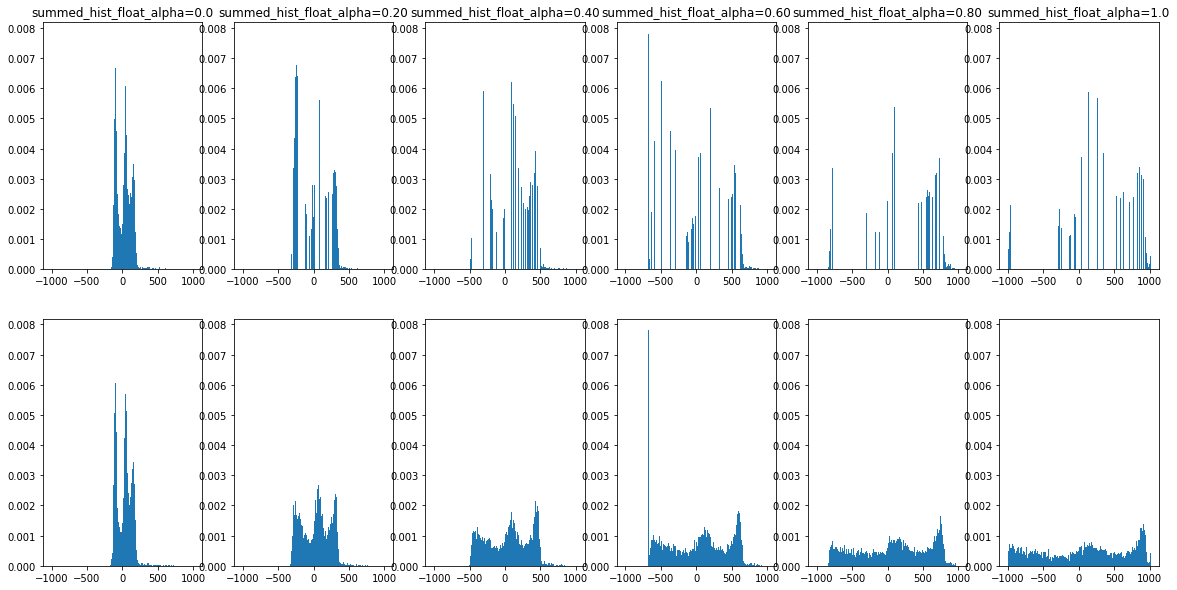

In [46]:
alpha = ['0.0', '0.20', '0.40', '0.60', '0.80', '1.0']
#alpha = ['1.0']
fig, axes = plt.subplots(2 ,6, figsize=(20, 10))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_int_alpha=" + a)
    axes[0][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_float_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_float_alpha=" + a)
    axes[1][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
   

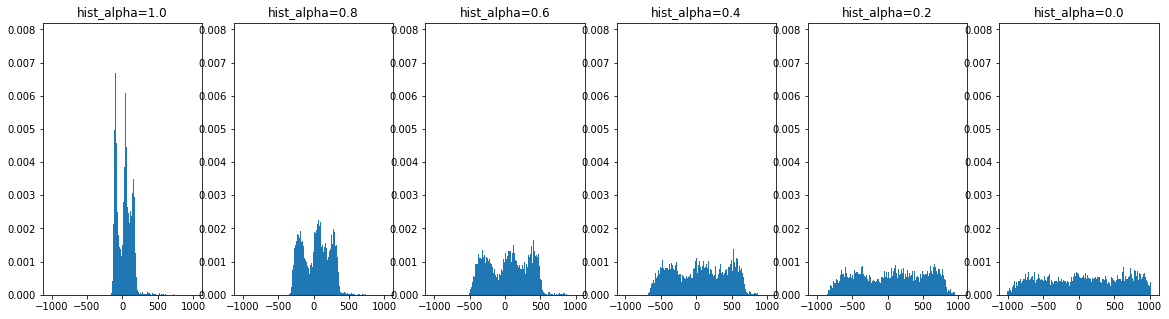

In [45]:
alpha = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
alpha.reverse()
fig, axes = plt.subplots(1 ,6, figsize=(20, 5))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/hist_'+ a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[ii].set_title("hist_alpha=" + a)
    axes[ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)

In [30]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
df = pd.read_csv("dfAboutKidneyAndCancer.csv")
df.head()

,Unnamed: 0,id,slice number,tag,Mean,Std,Var,Max,Min,Size
0,162,0,162,kidney,-37.253151,9.672718,93.561468,-11.861316,-11.861316,22
1,163,0,163,kidney,37.572537,49.860718,2486.091249,127.743541,127.743541,83
2,164,0,164,kidney,85.865282,86.790756,7532.635240,216.219592,216.219592,147
3,165,0,165,kidney,99.003225,94.184951,8870.804999,241.380014,241.380014,247
4,166,0,166,kidney,129.435100,84.773216,7186.498072,251.062135,251.062135,333


In [38]:
df_can = df.query("tag=='cancer'")
df_can_id = df_can.groupby('id')
df_can_id.head()

,Unnamed: 0,id,slice number,tag,Mean,Std,Var,Max,Min,Size
39414,107526,0,192,cancer,108.503576,29.433465,866.328841,159.202129,60.756507,9
39415,107527,0,193,cancer,121.447670,32.812393,1076.653144,178.043149,55.206411,20
39416,107528,0,194,cancer,131.009104,46.715202,2182.310071,204.502843,1.421013,46
39417,107529,0,195,cancer,141.070491,53.882059,2903.276279,247.621144,-15.397805,69
39418,107530,0,196,cancer,146.101227,62.604175,3919.282724,274.279406,-27.368338,95
...,...,...,...,...,...,...,...,...,...,...
52486,214482,209,325,cancer,5.562831,34.561447,1194.493588,62.024553,-45.347139,9
52487,214483,209,326,cancer,23.459182,31.698505,1004.795245,63.988746,-50.938850,17
52488,214484,209,327,cancer,40.161049,30.769446,946.758797,83.584497,-30.606094,25
52489,214485,209,328,cancer,48.279034,25.826263,666.995864,86.256312,-13.109755,36


In [174]:
df_can_id_size = df_can_id["Size"].mean()
df_can_size_sort = df_can_id_size.sort_values()
df_can_id_size = pd.DataFrame(df_can_id_size, columns = [ 'Size'])
print(df_can_id_size)
df_can_id_size.query('Size < 200').sort_values('Size').head()

           Size
id             
0    138.666667
1     82.916667
2    326.844828
3    150.324324
4    245.261905
..          ...
205  111.966667
206  405.036364
207  108.321429
208   70.035714
209   51.333333

[206 rows x 1 columns]


,Size
id,
120,21.666667
19,39.333333
72,46.550000
123,48.208333
156,50.212121


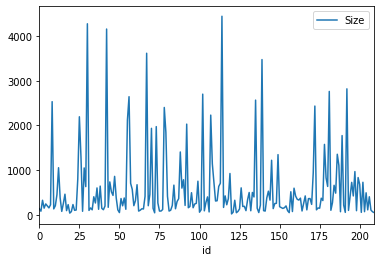

In [158]:
df_can_id_size.plot()


In [1]:
import cv2
import SimpleITK as sitk
from cut import caluculate_area

In [2]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/imaging.nii.gz')
imgArray = sitk.GetArrayFromImage(img)
label = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/segmentation.nii.gz')
labelArray = sitk.GetArrayFromImage(label)
labelArray.shape

(545, 545, 95)

In [56]:
SL, CL, AL = labelArray.shape
print(SL, CL, AL)

545 545 95


In [1]:
def searchBound(labelArray, length, axis):
    encounter = False
    startIdx = []
    endIdx = []
    if axis == 'sagittal':
        for l in range(length):
            sliceArray = labelArray[l, :, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

    if axis == 'coronal':
        for l in range(length):
            sliceArray = labelArray[:, l, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx        

    if axis == 'axial':
        for l in range(length):
            sliceArray = labelArray[:, :, l]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

def printchk(x):
    for s, v in globals().items():
        if id(v) == id(x):
            print('{} : {}'.format(s, x))
            break
            
    return 

def extractBoundingBox(labelArray, AL, CL):
    print("From {} to ".format(labelArray.shape), end="")
    
    startIdx, endIdx = searchBound(labelArray, AL, 'axial')
    labelArray = labelArray[:, :, startIdx[0] -1 : endIdx[0] + 1]
    
    print(labelArray.shape)
    
    print("From {} to ".format(labelArray.shape), end="")
    startIdx, endIdx = searchBound(labelArray, CL, 'coronal')
    labelArray = labelArray[:, startIdx[0] -1 : endIdx[0] + 1, :]
    
    print(labelArray.shape)
    
    return labelArray

def saveImage(saveImgArray, savePath, img):
    saveImg = sitk.GetImageFromArray(saveImgArray)
    saveImg.SetDirection(img.GetDirection())
    saveImg.SetOrigin(img.GetOrigin())
    saveImg.SetSpacing(img.GetSpacing())
    
    print('Saving image to ', savePath)
    sitk.WriteImage(saveImg, savePath, True)
    
    return

In [5]:
startIdx, endIdx = searchBound(labelArray, SL, 'sagittal')
printchk(startIdx)
printchk(endIdx)

startIdx : [145, 331]
endIdx : [220, 410]


In [6]:
leftArray = labelArray[startIdx[0] - 1 : endIdx[0] + 1, :, :]
rightArray = labelArray[startIdx[1] - 1 : endIdx[1] + 1, :, :]
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

leftArray shapes :  (77, 545, 95)
rightArray shapes :  (81, 545, 95)


In [7]:
leftArray = extractBoundingBox(leftArray, AL, CL)
rightArray = extractBoundingBox(rightArray, AL, CL)
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

From (77, 545, 95) to (77, 545, 26)
From (77, 545, 26) to (77, 107, 26)
From (81, 545, 95) to (81, 545, 34)
From (81, 545, 34) to (81, 73, 34)
leftArray shapes :  (77, 107, 26)
rightArray shapes :  (81, 73, 34)


In [8]:
saveImage(leftArray, 'test/left.mha', label)
saveImage(rightArray, 'test/right.mha', label)

Saving image to  test/left.mha
Saving image to  test/right.mha


# Use OBB

In [59]:
from pyobb.obb import OBB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi, cos, sin, sqrt

In [5]:
# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

NameError: name 'pi' is not defined

In [61]:
v = sphere(1, (0,0,0))

In [62]:
x = []
y = []
z = []
for xx, yy, zz in v:
    x.append(xx)
    y.append(yy)
    z.append(zz)

In [63]:
a = []
b = []
c = []
for xx, yy, zz in obb.points:
    a.append(xx)
    b.append(yy)
    c.append(zz)


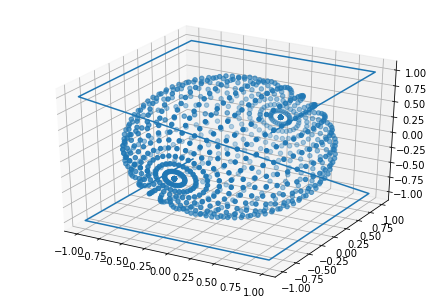

In [64]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)
ax.plot(a, b, c)
plt.show()

In [1]:
import SimpleITK as sitk
import numpy as np
from cut import caluculate_area
from pyobb.obb import OBB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import math
from math import cos as cos
from math import sin as sin

In [3]:
def searchBound(labelArray, length, axis):
    encounter = False
    startIdx = []
    endIdx = []
    if axis == 'sagittal':
        for l in range(length):
            sliceArray = labelArray[l, :, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

    if axis == 'coronal':
        for l in range(length):
            sliceArray = labelArray[:, l, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx        

    if axis == 'axial':
        for l in range(length):
            sliceArray = labelArray[:, :, l]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

def printchk(x):
    for s, v in globals().items():
        if id(v) == id(x):
            print('{} : {}'.format(s, x))
            break
            
    return 

def extractBoundingBox(labelArray, AL, CL):
    print("From {} to ".format(labelArray.shape), end="")
    
    startIdx, endIdx = searchBound(labelArray, AL, 'axial')
    labelArray = labelArray[:, :, startIdx[0] -1 : endIdx[0] + 1]
    
    print(labelArray.shape)
    
    print("From {} to ".format(labelArray.shape), end="")
    startIdx, endIdx = searchBound(labelArray, CL, 'coronal')
    labelArray = labelArray[:, startIdx[0] -1 : endIdx[0] + 1, :]
    
    print(labelArray.shape)
    
    return labelArray

def saveImage(saveImgArray, savePath, img):
    saveImg = sitk.GetImageFromArray(saveImgArray)
    saveImg.SetDirection(img.GetDirection())
    saveImg.SetOrigin(img.GetOrigin())
    saveImg.SetSpacing(img.GetSpacing())
    
    print('Saving image to ', savePath)
    sitk.WriteImage(saveImg, savePath, True)
    
    return

def pythagorian(x, y):#x, y = (x cordinate, y cordinate, zcordinate)
    l = 0
    d = len(x)
    for i in range(d):
        l += (x[i] - y[i])**2
    
    return math.sqrt(l)



In [50]:
# Read image
img = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/imaging.nii.gz')
imgArray = sitk.GetArrayFromImage(img)
label = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/segmentation.nii.gz')
labelArray = sitk.GetArrayFromImage(label)
SL, CL, AL = labelArray.shape
print(SL, CL, AL)

545 545 95


In [52]:
# Find a border dividing the kidney into a separate space 
startIdx, endIdx = searchBound(labelArray, SL, 'sagittal')
printchk(startIdx)
printchk(endIdx)

startIdx : [145, 331]
endIdx : [220, 410]


In [53]:
# Divide the kidney into leftArray and rightArray
leftArray = labelArray[ : startIdx[1] - 1, :, :]
rightArray = labelArray[endIdx[0] + 1 : , :, :]
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

leftArray shapes :  (330, 545, 95)
rightArray shapes :  (324, 545, 95)


In [54]:
# Find kidney region
idx = np.where(rightArray > 0)

In [62]:
# Preprocessing for OBB
vertics = np.stack([*idx], axis=-1)
vertics[0:10]

array([[109, 295,  53],
       [110, 293,  53],
       [110, 294,  50],
       [110, 294,  52],
       [110, 294,  53],
       [110, 295,  50],
       [110, 295,  52],
       [110, 295,  53],
       [110, 295,  54],
       [110, 296,  50]])

In [63]:
# Implement OBB
obb = OBB.build_from_points(vertics)

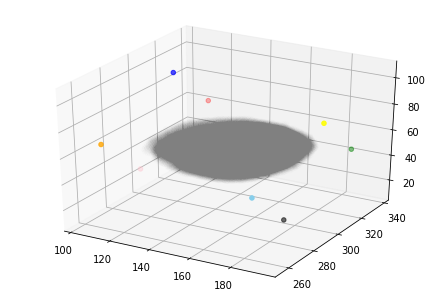

In [65]:
# Plot kidney and bouding box
a = []
b = []
c = []
cc = []
colors = ["red", "blue", "yellow", "green", "orange", "pink", "black", "skyblue"]
i = 0
for xx, yy, zz in obb.points:
    a.append(xx)
    b.append(yy)
    c.append(zz)
    cc.append(i)
    i += 1
cmap = ListedColormap(colors)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*idx, alpha=0.005, color="gray")
ax.scatter(a, b, c, c=cc, cmap=cmap)  
plt.show()

In [66]:
# Output 8 vertics of bouding box
obb.points

[array([111.83157161, 337.7658473 ,  60.77901597]),
 array([120.42187223, 298.43858838, 105.58983368]),
 array([194.65793642, 296.43224861,  89.59784807]),
 array([186.0676358 , 335.75950754,  44.78703036]),
 array([111.9397592 , 257.56412453,  71.34326553]),
 array([103.34945858, 296.89138346,  26.53244782]),
 array([177.58552277, 294.88504369,  10.54046221]),
 array([186.1758234 , 255.55778476,  55.35127993])]

In [67]:
# Minimum vertics for defining bounding box
index = ((0, 1), (0, 3), (0, 5))

In [68]:
def getSortedDistance(obbPoints, index):
    length = []
    out = []
    for i in index:
        l = pythagorian(obbPoints[i[0]], obbPoints[i[1]])
        length.append((l, (obbPoints[i[0]], obbPoints[i[1]])))
    
    length = sorted(length, reverse=True)
    for _ , i in length:
        out.append(i)
    
    return out

def getGradient(x, y, axis):# x = (x cordinate, y cordinate, z cordinate)
    #axis : x->0, y->1, z->2
    
    g = []
    d = len(x)
    esp = 10**(-9)
    for i in range(d):
        g.append(x[i] - y[i])
    
    if axis == 0:
        return g[1] / (g[2] + esp)
        #return g[1] / g[2]
    
    if axis == 1:
        return g[0] / (g[2] + esp)
        #return g[0] / g[2]
    
    if axis == 2:
        return g[1] / (g[2] + esp)
        #return g[1] / g[2]

def getRadian(points, axis):
    gradient = getGradient(*points, axis)
    radian = math.atan(gradient)
    
    return radian

def makeRotationMatrix(radian, axis):
    if axis == 0:
        matrix = np.array([[1, 0, 0], 
                           [0, cos(radian), (-1) * sin(radian)],
                           [0, sin(radian), cos(radian)]])
        
        return matrix
    
    if axis == 1:
        matrix = np.array([[cos(radian), 0, (-1) * sin(radian)],
                           [0, 1, 0], 
                           [sin(radian), 0, cos(radian)]])
        
        return matrix
    
    if axis == 2:
        matrix = np.array([[cos(radian), (-1) * sin(radian), 0], 
                           [sin(radian), cos(radian), 0],
                           [0, 0, 1]])
        
        return matrix
    

In [69]:
# Calucualte the length of each side of bouding box and output in decending order
points = getSortedDistance(obb.points, index)
points

[(array([111.83157161, 337.7658473 ,  60.77901597]),
  array([186.0676358 , 335.75950754,  44.78703036])),
 (array([111.83157161, 337.7658473 ,  60.77901597]),
  array([120.42187223, 298.43858838, 105.58983368])),
 (array([111.83157161, 337.7658473 ,  60.77901597]),
  array([103.34945858, 296.89138346,  26.53244782]))]

In [71]:
# Caluculate angles(radian) to make bounding box parallel to the axis
radianX = getRadian(points[0], 0)
radianY = getRadian(points[0], 1)
radianZ = getRadian(points[1], 2)
printchk(radianX)
printchk(radianY)
printchk(radianZ)

radianX : 0.12480698404143817
radianY : -1.3586180802503853
radianZ : -0.7203168731381026


In [72]:
# Caluculate matrixes to make bounding box parallel to the axis
matrixX = makeRotationMatrix(radianX, 0)
matrixY = makeRotationMatrix(radianY, 1)
matrixZ = makeRotationMatrix(radianZ, 2)
rotationMatrix = matrixZ @ matrixY @ matrixX

In [80]:
# Give a caluculation to go
x = rotationMatrix @ points[0][0]
x = np.array(x, dtype=np.int)
print(x)
x = rotationMatrix @ points[0][1]
x = np.array(x, dtype=np.int)
print(x)
x = rotationMatrix @ points[1][1]
x = np.array(x, dtype=np.int)
print(x)
x = rotationMatrix @ points[2][1]
x = np.array(x, dtype=np.int)
print(x)

[308 164 -87]
[ 308  164 -163]
[309 104 -87]
[254 163 -87]


In [81]:
print(rightArray.shape)
print(rotationMatrix.shape)
print(rotationMatrix)

(324, 545, 95)
(3, 3)
[[ 0.15827861  0.74595516  0.64691482]
 [-0.13890984  0.66548004 -0.73337601]
 [-0.97757452  0.0262149   0.20895177]]


In [82]:
#SL, CL, AL   
SL = 2
CL = 3
AL = 4
# For affine transformation, make outputArray is matrix with the coordinates for each pixels
x, y, z = np.mgrid[:SL, :CL, :AL]
outputArray = np.stack([x, y, z], axis=-1)
print(outputArray.shape)

(2, 3, 4, 3)


In [83]:
# For affine transformation, make inverse matrix
invAffine = np.linalg.inv(rotationMatrix)
# Caluculate the coordinates before conversion that each pixel after conversion should refer to 
refCoords = np.einsum('ijkm, ml->ijkl', outputArray, invAffine)
refCoords.shape

(2, 3, 4, 3)

In [84]:
# Nearest neighbor
refCoordsNearest = np.where(refCoords > 0, refCoords + 0.5, refCoords - 0.5).astype(int)
type(refCoordsNearest[0][0][0][0])

numpy.int64

In [123]:
# Linear interpolation

# Caluculate 8 vertics around
linearCoords = {} #linearCoords['xyz']
linearCoords['000'] = refCoords.astype(int)
linearCoords["100"] = linearCoords['000'] + [1, 0, 0]
linearCoords["010"] = linearCoords['000'] + [0, 1, 0] 
linearCoords["001"] = linearCoords['000'] + [0, 0, 1]
linearCoords["110"] = linearCoords['000'] + [1, 1, 0]
linearCoords["101"] = linearCoords['000'] + [1, 0, 1]
linearCoords["011"] = linearCoords['000'] + [0, 1, 1]
linearCoords["111"] = linearCoords['000'] + [1, 1, 1]
print(linearCoords['000'][0,0,3,:])
print(linearCoords['100'][0,0,3,:])
print(linearCoords['010'][0,0,3,:])
print(linearCoords['001'][0,0,3,:])
print(linearCoords['110'][0,0,3,:])
print(linearCoords['101'][0,0,3,:])
print(linearCoords['011'][0,0,3,:])
print(linearCoords['111'][0,0,3,:])
linearCoords['000'].shape

[ 1 -2  0]
[ 2 -2  0]
[ 1 -1  0]
[ 1 -2  1]
[ 2 -1  0]
[ 2 -2  1]
[ 1 -1  1]
[ 2 -1  1]


(2, 3, 4, 3)

In [118]:
diff = (refCoords - linearCoords['000'])
alpha = diff[..., 0]
beta = diff[..., 1]
gamma = diff[..., 2]
print(alpha.shape, beta.shape, gamma.shape)

(2, 3, 4) (2, 3, 4) (2, 3, 4)


In [120]:
linearWeight = {}

linearWeight['000'] = (1 - alpha) * (1 - beta) * (1 - gamma)
linearWeight['100'] = alpha * (1 - beta) * (1 - gamma)
linearWeight['010'] = (1 - alpha) * beta * (1 - gamma)
linearWeight['001'] = (1 - alpha) * (1 - beta) * gamma
linearWeight['110'] = alpha * beta * (1 - gamma)
linearWeight['101'] = alpha * (1 - beta) * gamma
linearWeight['011'] = (1 - alpha) * beta * gamma
linearWeight['111'] = alpha * beta * gamma
linearWeight['000'].shape

(2, 3, 4)

In [121]:
refCoordsLinear = {}
for direction in linearCoords.keys():
    coords = linearCoords[direction]
    weight = linearWeight[direction]
    
    refCoordsLinear[direction]  = np.einsum('', weight,imgArray[coords[..., 0], coords[..., 1], coords[..., 2]] )

ValueError: einstein sum subscripts string contains too many subscripts for operand 0